### Comparing Midpoints from FlowDMS and Single-Variant Validations

#### Import Data

In [2]:
library(ggpubr)
library(patchwork)
library(ggrepel)
library(ggbeeswarm)
library(drc)
library(tidyverse)

In [3]:
midpoints <- read_tsv("../sumstats/BMS/BMS-2/ExpressionDMS_midpoints_rescaled.tsv")

flowpoints <- tibble(
    Position = c(154, 634, 638, 744, 928, 930, 930, 996, 1010, 1014, 1104),
    wt_aa = c("E", "G", "R", "R", "A", "K", "K", "G", "G", "L", "P"),
    AA = c("*", "E", "*", "G", "V", "E", "R", "R", "D", "P", "A"),
    flow_score = c(0.52, 1.42, 1.08, 0.63, 1.63, 0.74, 0.97, 1.24, 1.03, 0.81, 1.11)
)

Rows: 23718 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): AA
dbl (8): Chunk, Position, Midpoint, Midpoint_Lower, Midpoint_Upper, ScaledSc...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Fit Sigmoid

In [4]:
ll4 <- function(slope, emin, emax, ec50, x) {
  value <- emin + ((emax - emin) / (1 + 10**(slope * (log10(ec50) - log10(x)))))
  return(value)
}

drc_data <- midpoints %>%
    left_join(flowpoints) %>%
    filter(!is.na(flow_score)) %>%
    dplyr::select(Midpoint, flow_score)

drc_model <- drm(drc_data, fct = LL.4())
drc_coefs <- coef(drc_model)

summary(drc_model)

Joining with `by = join_by(Position, AA)`



Model fitted: Log-logistic (ED50 as parameter) (4 parms)

Parameter estimates:

                Estimate Std. Error t-value   p-value    
b:(Intercept) -14.134547   4.158435  -3.399   0.01146 *  
c:(Intercept)   0.297325   0.013782  21.573 1.159e-07 ***
d:(Intercept)   0.690842   0.036161  19.105 2.680e-07 ***
e:(Intercept)   1.274536   0.031654  40.265 1.519e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error:

 0.02815884 (7 degrees of freedom)

#### Plotting

In [5]:
scatter_compare <- midpoints %>%
    left_join(flowpoints) %>%
    filter(!is.na(flow_score)) %>%
    mutate(AA = if_else(AA == "*", "Stop", AA)) %>%
    ggplot() +
        geom_point(aes(y = Midpoint,
                       x = flow_score), size = 3) +
        geom_label_repel(aes(y = Midpoint,
                             x = flow_score,
                             label = str_c(wt_aa, Position, AA))) +
        theme_pubr(base_size = 16) +
        ylim(c(0.2,0.8)) +
        xlab("Flow Mode") + ylab("FlowDMS Midpoint") +
        stat_function(fun = ll4, args = list(emin = drc_coefs[2],
                                             emax = drc_coefs[3],
                                             ec50 = drc_coefs[4],
                                             slope = -drc_coefs[1])) +
        geom_hline(yintercept = 0.653) +
        geom_vline(xintercept = 1.58)

full_dist <- midpoints %>%
    ggplot() +
        geom_quasirandom(aes(x = 1, y = Midpoint)) +
        ylim(c(0.2, 0.8)) +
        theme_void()

Joining with `by = join_by(Position, AA)`


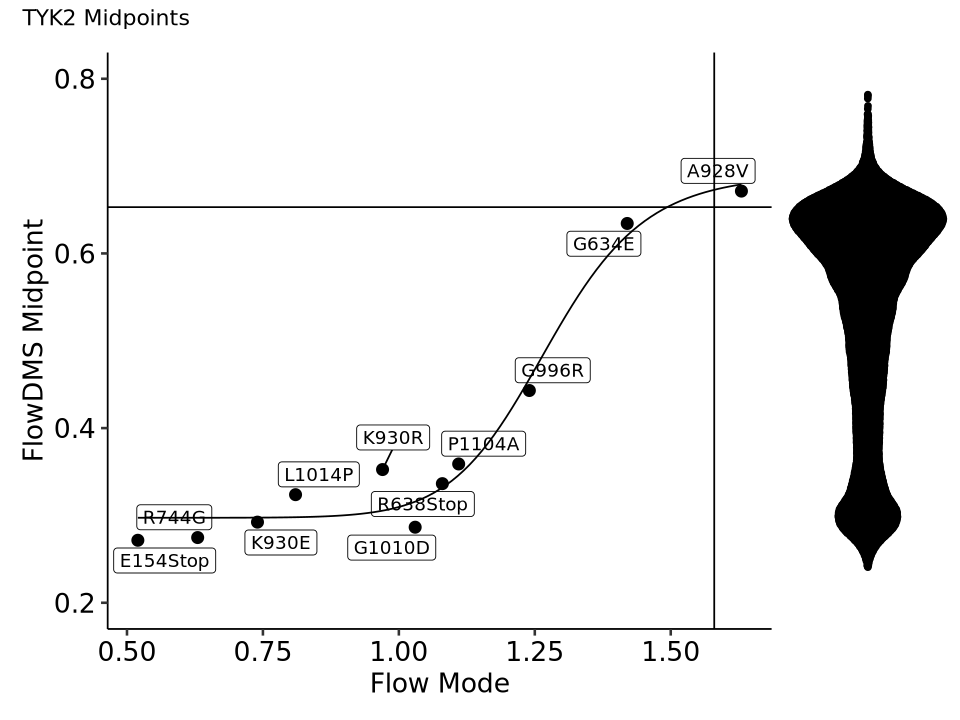

In [6]:
options(repr.plot.width = 8, repr.plot.height = 6)

scatter_compare +
    full_dist +
    plot_layout(widths = c(4,1)) +
    plot_annotation(title = "TYK2 Midpoints")